### IC intrinsic task

**Author**: Ben Peloquin
    
**Date**: 20190515

#### Notes
* Suggestion from noah to do extrinsic task

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import seaborn as sns
import sys
import itertools as it

import torch
import torchvision
from torchvision import transforms


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sapir_image_captions import GLOBAL_TOKENS, SOS_TOKEN, EOS_TOKEN, PAD_TOKEN
from sapir_image_captions.checkpoints import load_checkpoint
from sapir_image_captions.multi_30k.dataset import CaptionTask2Dataset
from sapir_image_captions.models import batch_beam_search_caption_generation, beam_search_caption_generation
from sapir_image_captions.utils import text2tensor, tensor2text, remove_tokens

In [2]:
models_dir = "/Users/benpeloquin/Data/projects/sapir_image_captions/trained_models"
folder_template = "20190514-ic-{}-{}"
folders = list(it.product(range(1, 6), ["de", "en"]))
create_fp = \
    lambda version, language: os.path.join(models_dir, folder_template.format(language, version))
# Tuples of version, language, path
model_paths = [(language, version, create_fp(version, language)) for version, language in folders]

Load models

In [3]:
loaded_models = {"{}-{}".format(language, version): \
          load_checkpoint(path) for language, version, path in model_paths}

INFO:root:
    Loading best model -->
        Epoch:	8
        train loss:	6.973089830727413

        dev loss:	8.247136684564444

        test loss:	8.20265514755249

    
INFO:root:
    Loading best model -->
        Epoch:	11
        train loss:	6.675711517991691

        dev loss:	7.223170372155996

        test loss:	7.1801346454620365

    
INFO:root:
    Loading best model -->
        Epoch:	7
        train loss:	7.172362615651098

        dev loss:	8.290670679871146

        test loss:	8.161521884918212

    
INFO:root:
    Loading best model -->
        Epoch:	11
        train loss:	6.6960221681266

        dev loss:	7.367235527941461

        test loss:	7.318887409210205

    
INFO:root:
    Loading best model -->
        Epoch:	7
        train loss:	7.246408970273774

        dev loss:	8.124966893675765

        test loss:	8.108751970291138

    
INFO:root:
    Loading best model -->
        Epoch:	8
        train loss:	6.9675295873181575

        dev loss:	7.35509158591547


In [4]:
device = torch.device('cpu')

en_encoder_1, en_decoder_1, en_vocab_1, en_checkpoint_1 = loaded_models["en-1"]
en_encoder_2, en_decoder_2, en_vocab_2, en_checkpoint_2 = loaded_models["en-2"]
en_encoder_3, en_decoder_3, en_vocab_3, en_checkpoint_3 = loaded_models["en-3"]
en_encoder_4, en_decoder_4, en_vocab_4, en_checkpoint_4 = loaded_models["en-4"]
en_encoder_5, en_decoder_5, en_vocab_5, en_checkpoint_5 = loaded_models["en-5"]
de_encoder_1, de_decoder_1, de_vocab_1, de_checkpoint_1 = loaded_models["de-1"]
de_encoder_2, de_decoder_2, de_vocab_2, de_checkpoint_2 = loaded_models["de-2"]
de_encoder_3, de_decoder_3, de_vocab_3, de_checkpoint_3 = loaded_models["de-3"]
de_encoder_4, de_decoder_4, de_vocab_4, de_checkpoint_4 = loaded_models["de-4"]
de_encoder_5, de_decoder_5, de_vocab_5, de_checkpoint_5 = loaded_models["de-5"]

en_encoder_1 = en_encoder_1.to(device)
en_encoder_2 = en_encoder_2.to(device)
en_encoder_3 = en_encoder_3.to(device)
en_encoder_4 = en_encoder_4.to(device)
en_encoder_5 = en_encoder_5.to(device)

en_decoder_1 = en_decoder_1.to(device)
en_decoder_2 = en_decoder_2.to(device)
en_decoder_3 = en_decoder_3.to(device)
en_decoder_4 = en_decoder_4.to(device)
en_decoder_5 = en_decoder_5.to(device)

de_encoder_1 = de_encoder_1.to(device)
de_encoder_2 = de_encoder_2.to(device)
de_encoder_3 = de_encoder_3.to(device)
de_encoder_4 = de_encoder_4.to(device)
de_encoder_5 = de_encoder_5.to(device)

de_decoder_1 = de_decoder_1.to(device)
de_decoder_2 = de_decoder_2.to(device)
de_decoder_3 = de_decoder_3.to(device)
de_decoder_4 = de_decoder_4.to(device)
de_decoder_5 = de_decoder_5.to(device)

models = [("en-1", en_encoder_1, en_decoder_1, en_vocab_1),
          ("en-2", en_encoder_2, en_decoder_2, en_vocab_2),
          ("en-3", en_encoder_3, en_decoder_3, en_vocab_3),
          ("en-4", en_encoder_4, en_decoder_4, en_vocab_4),
          ("en-5", en_encoder_5, en_decoder_5, en_vocab_5),
          ("de-1", de_encoder_1, de_decoder_1, de_vocab_1),
          ("de-2", de_encoder_2, de_decoder_2, de_vocab_2),
          ("de-3", de_encoder_3, de_decoder_3, de_vocab_3),
          ("de-4", de_encoder_4, de_decoder_4, de_vocab_4),
          ("de-5", de_encoder_5, de_decoder_5, de_vocab_5)]

en_hyper_params = vars(en_checkpoint_1['cmd_line_args'])
de_hyper_params = vars(de_checkpoint_1['cmd_line_args'])

In [5]:
# Notes
# version doesn't really matter here, because for this analysis we're just interested
# in the images (language doesn't really matter.)
data_dir = "/Users/benpeloquin/Data/general/multi30k/"
batch_size = 64

test_en_dataset = \
    CaptionTask2Dataset(data_dir, "test", year=en_hyper_params['year'],
                        caption_ext="en",
                        version=1,
                        image_size=en_hyper_params['image_size'],
                        max_seq_len=en_hyper_params['max_seq_len'],
                        vocab=en_vocab_1,
                        max_size=en_hyper_params['max_size'])

test_de_dataset = \
    CaptionTask2Dataset(data_dir, "test", year=de_hyper_params['year'],
                        caption_ext="de",
                        version=1,
                        image_size=de_hyper_params['image_size'],
                        max_seq_len=de_hyper_params['max_seq_len'],
                        vocab=de_vocab_1,
                        max_size=de_hyper_params['max_size'])

test_en_loader =  torch.utils.data.DataLoader(
    test_en_dataset, batch_size=32)

In [6]:
def get_len_from_sequences(seq):
    lens = []
    for i, s in enumerate(seq):
        if i == 0:
            lens.append(len(s))
        else:
            lens.append(lens[i-1]+len(s))
    return np.array(lens)

def get_batch_mean_alphas_(captions, alphas):
    lens = get_len_from_sequences(captions)
    alphas_split = np.split(alphas, lens)
    mean_alphas = [alphas.mean(0) for alphas in alphas_split if alphas.shape[0]!=0] 
    assert len(mean_alphas) == len(captions)
    return mean_alphas

def get_batch_mean_alphas(images, encoder, decoder, vocab, device, max_seq_len):
    captions, alphas = \
        batch_beam_search_caption_generation(images, encoder, decoder, vocab, device, max_seq_len)
    mean_alphas = get_batch_mean_alphas_(captions, alphas)
    return mean_alphas, captions

k = 5
max_seq_len = 32
all_images = []
for batch_idx, batch in enumerate(test_en_loader):
    X_images = batch["image"]
    all_images.append(X_images)
    res = []
    for model_nam, enc, dec, vocab in models:
        alphas, captions = \
            get_batch_mean_alphas(X_images, enc, dec, vocab, device, max_seq_len)
        res.append((model_nam, alphas, captions))
    break

KeyboardInterrupt: 

In [ ]:
en_data = []
en_captions = []
de_data = []
de_captions = []
for meta, data, caption in res:
    if "en" in meta:
        en_data.append(data)
        en_captions.append(en_captions)
    else:
        de_data.append(data)
        de_captions.append(de_captions)

In [219]:
# samples, n_images, height, width
en_data = np.stack(en_data).swapaxes(1, 0)
de_data = np.stack(de_data).swapaxes(1, 0)

In [220]:
from scipy.stats import entropy, ttest_ind
from statsmodels.stats.multitest import multipletests

In [221]:
def get_pval(v1, v2):
    return ttest_ind(v1, v2).pvalue

def get_pvals_and_entropies(m1, m2):
    """
    m1: np.array (samples, rows, cols)
        Alpha matrix.
    m2: np.array (samples, rows, cols)
        Alpha matrix.
        
    """
    assert m1.shape == m2.shape
    pvals = np.ones(m1[0, :].shape)
    for i in range(m1.shape[1]):
        for j in range(m1.shape[2]):
            pvals[i, j] = get_pval(m1[:, i, j], m2[:, i, j])
    m1_avg = m1.mean(0)
    m2_avg = m2.mean(0)
    m1_avg = m1_avg / m1_avg.sum()
    m2_avg = m2_avg / m2_avg.sum()
    ent = entropy(m1_avg.reshape(-1), m2_avg.reshape(-1))
    return pvals, ent

# en_data[0, :].shape
n_images = en_data.shape[0]
pvals = []
entropies = []
for i in range(n_images):
    pval, ent = get_pvals_and_entropies(en_data[i, :], de_data[i, :])
    pvals.append(pval)
    entropies.append(ent)

[[...], [...], [...], [...], [...]]

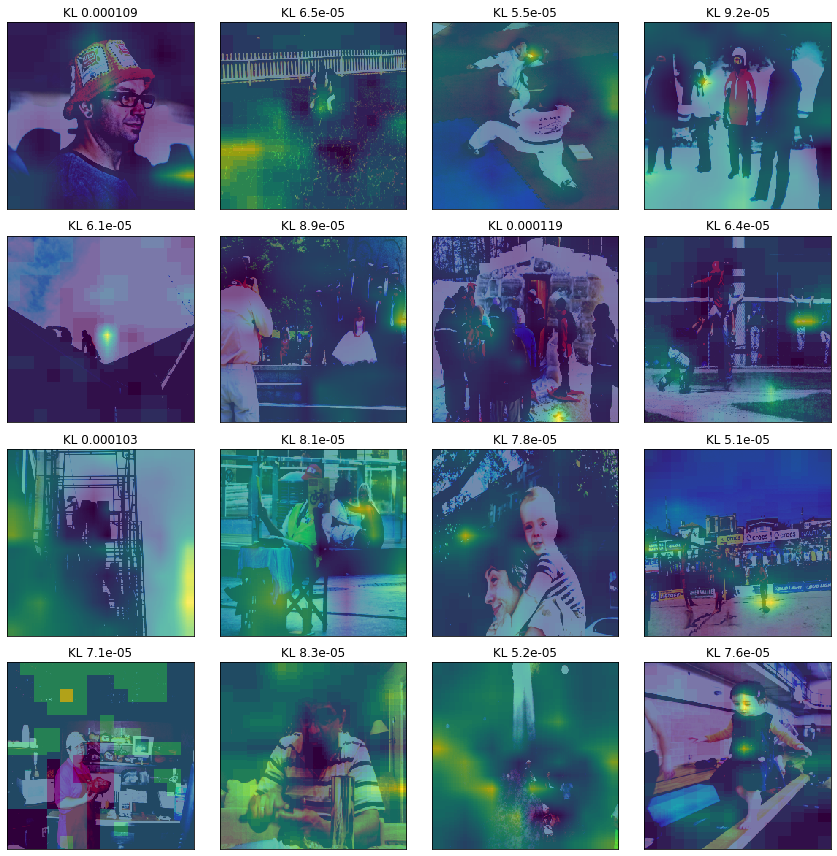

In [217]:
plt.figure(figsize=(12,12))
vmin = np.min([np.min(val) for val in pvals])
vmax = np.max([np.max(val) for val in pvals])
vmin = 0
vmax = 1
pvals = pvals[:16]
height = width = int(len(pvals))
for i in range(len(pvals)):
    plt.subplot(int(np.sqrt(len(pvals))), int(np.sqrt(len(pvals))), i+1)
    plt.title("KL {}".format(round(entropies[i], 6)))
    plt.imshow(rescaler(to_pil(torch.FloatTensor(pvals[i]))))
    plt.imshow(X_images[i, :].permute(1, 2, 0), alpha=0.3)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
plt.tight_layout()